# 第三章 分类

## 设置

首先，导入一些常用模块，确保 MatplotLib内联绘制图形并准备一个函数来保存图形。 然后检查是否安装了Python3.5或更高版本（虽然 Python 2.x 可以工作，但它已被弃用，因此我们强烈建议改用Python 3），以及Scikit-Learn ≥0.20。

In [1]:
# Python ≥ 3.5 is required
import sys
assert sys.version_info >= (3,5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "google.kaggle" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 3.1 MNIST

**警告：** 从 Scikit-Learn 0.24 开始，`fetch_openml()` 默认返回 Pandas `DataFrame`。 为了避免这种情况并保持与书中相同的代码，我们使用 `as_frame=False`。

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# 查看数组数据
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Saving figure fig1_some_digit_plot


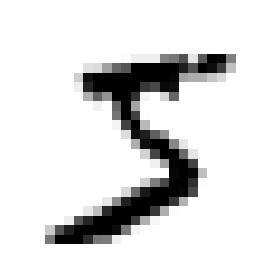

In [5]:
# 使用Matplotlib的imshow()函数显示
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")

# saving figure
save_fig("fig1_some_digit_plot")

plt.show()

In [6]:
# 看起来像5，而标签告诉我们没错：
y[0]

'5'

In [7]:
# 将字符转换为数字
y = y.astype(np.uint8)

In [8]:
# 准备测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 训练二元分类器

In [9]:
# 为此分类任务创建目标向量
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**注意**：在 Scikit-Learn 的未来版本中，某些超参数将具有不同的默认值，例如 `max_iter` 和 `tol`。 为了面向未来，我们明确地将这些超参数设置为它们未来的默认值。 为简单起见，这在书中没有显示。

In [10]:
# 创建一个SGDClassifier并在整个训练集上进行训练
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# 用它来检测数字5的图片了：
sgd_clf.predict([some_digit])

array([ True])

## 3.3 性能测量

评估分类器比评估回归器要困难得多，因此本章将用很多篇幅来讨论这个主题，同时会涉及许多性能考核的方法。

### 3.3.1 使用交叉验证测量准确率

In [12]:
# 通过sklearn提供的cross_val_score()实现交叉验证
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# 自行实现交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9669 0.91625 0.96785

0.9669
0.91625
0.96785


In [14]:
# 分类为非5的分类器
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

没错，准确率超过90%！这是因为只有大约10%的图片是数字5，所以如果你猜一张图不是5，90%的概率你都是正确的，简直超越了大预言家！

这说明**准确率通常无法成为分类器的首要性能指标**，特别是当你处理有偏数据集时（即某些类比其他类更为频繁）

### 3.3.2 混淆矩阵

In [16]:
# 计算混淆矩阵，使用cross_val_predict()函数：
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
# 使用confusion_matrix()函数来获取混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
# 一个完美的分类器只有真正类和真负类，
# 所以它的混淆矩阵只会在其对角线（左上到右下）上有非零值
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 3.3.3 精度和召回率

In [19]:
# Scikit-Learn提供了计算多种分类器指标的函数，包括精度和召回率：
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm [1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
cm[1, 1] / (cm[1, 1] + cm[0, 1])

0.8370879772350012

In [23]:
# 计算f1
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### 3.3.4 精度/召回率权衡

In [25]:
# Scikit-Learn不允许直接设置阈值，但是可以访问它用于预测的决策分数
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
# 提升阈值
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
# 如何决定使用什么阈值呢
# 使用`cross_val_predict()`函数获取训练集中所有实例的分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [30]:
# 计算所有可能的阈值的精度和召回率
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


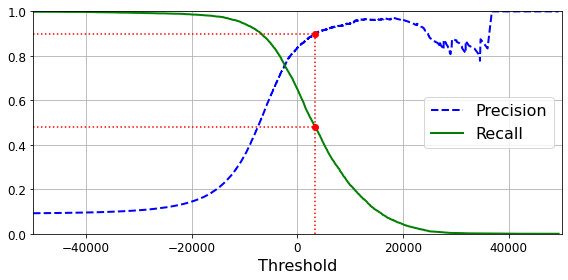

In [33]:
# 使用Matplotlib绘制精度和召回率相对于阈值的函数图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [35]:
# 提供至少90%精度的最低阈值
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC曲线